In [1]:
import vof
from vof import forecaster
from vof import optimizer

In [2]:
#pip install altair

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import pandas as pd
import statsmodels.api as sm
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
import statsmodels.tsa.stattools
import sklearn
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
import time
import random
#from fbprophet import Prophet
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from datetime import date
import nevergrad as ng
from joblib import Parallel, delayed

from darts.utils import timeseries_generation as tg
from darts import TimeSeries
from darts.metrics import rmse, mape
# from darts import SeasonalityMode, TrendMode, ModelMode

from darts.models import Theta, FFT, ExponentialSmoothing, Prophet, RegressionModel,NaiveSeasonal,LightGBMModel,RandomForest,forecasting
# import darts.models
import holidays


plt.rcParams['figure.figsize'] = [18, 8]
plt.rcParams.update({'font.size': 22})

INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,y,Temperature,Day_of_week,Hour_of_day,Holidays,Smoothed_temperature
time,,,,,,
2018-01-01 00:00:00,8.143500,3.50,0,0,1,NaN
2018-01-01 01:00:00,7.789000,3.74,0,1,1,NaN
2018-01-01 02:00:00,7.470750,2.57,0,2,1,NaN
2018-01-01 03:00:00,7.354500,1.96,0,3,1,NaN
2018-01-01 04:00:00,7.374250,1.44,0,4,1,NaN
...,...,...,...,...,...,...
2020-01-01 19:00:00,9.021000,0.19,2,19,1,NaN
2020-01-01 20:00:00,8.912250,0.62,2,20,1,NaN
2020-01-01 21:00:00,9.148667,-2.91,2,21,1,NaN


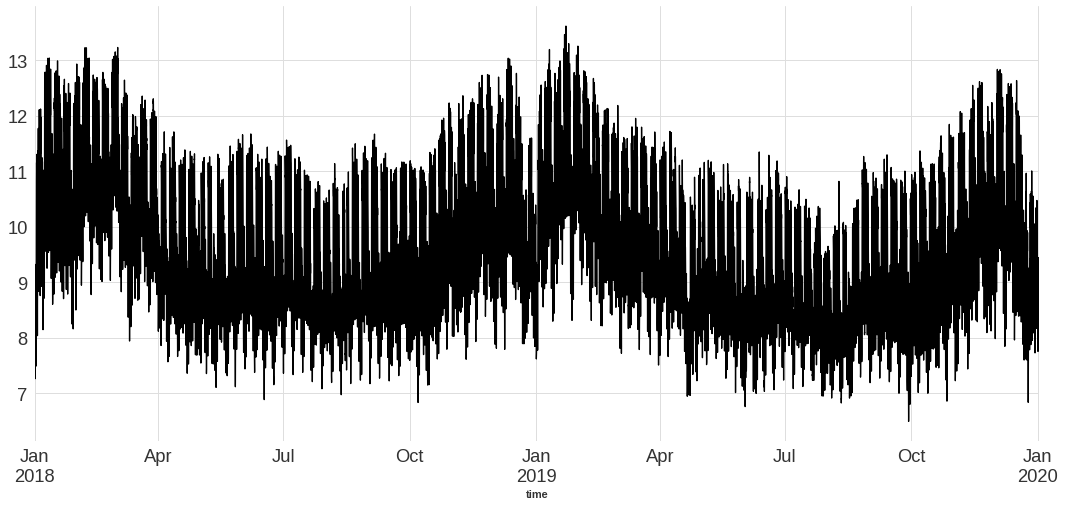

In [4]:
# data = pd.read_parquet('data/Elia/data_load_forecasts.parquet').loc['2019-01-01':'2019-04-25']
data = pd.read_parquet('data/Elia/f4sg.parquet')#.loc['2019-01-01':'2019-04-25']
data = data.reset_index()
# data['time'] = pd.to_datetime(data.time).dt.tz_localize(None)
data['Day_of_week'] = data['time'].dt.dayofweek
data['Hour_of_day'] = data['time'].dt.hour
data = data.set_index('time')
data['Holidays'] = pd.Series(data.index).apply(lambda x: holidays.CountryHoliday('BE').get(x)).values
data['Holidays'] = data['Holidays'].astype('bool').astype('int')
data.columns = ['y','Temperature','Day_of_week','Hour_of_day','Holidays']
data['Smoothed_temperature'] = data.Temperature.rolling(337, center=True).mean()
data.y = data.y/1000
data.y.plot()
data


In [5]:
# data = pd.read_csv("data/district/Actuals.csv", index_col=0, parse_dates=True).loc['2019-01-01':'2019-04-25']
# data.head(5)
# data.columns = ['y','Pressure_kpa','Cloud Cover (%)','Humidity (%)','Temperature (C)','Wind Direction (deg)','Wind Speed (kmh)']
# data.y = data.y/100000

# data.reset_index(inplace=True)
# data['sin_hour'] = np.sin(2*np.pi*data.Time.dt.hour/24)
# data['cos_hour'] = np.cos(2*np.pi*data.Time.dt.hour/24)

# data.set_index('Time', inplace=True)
# data.y.plot()
# data

# Creating forecast from Fact data

## Estimating Lags and adding them to the object

In [6]:
# def estimateSignificantLags(ts, nlags = 360, significantLags = 11): 
#     pacf = sm.tsa.stattools.pacf(ts, nlags)
#     lags = np.argsort(-np.abs(pacf))[1:significantLags+1]
#     plt.plot(pacf,'*--')
#     plt.plot(lags,pacf[lags],'o')
#     return lags

In [7]:
# lags = estimateSignificantLags(data.y, significantLags = 10)
# # add lags for certain days
# lags = np.unique(np.hstack([lags]))
# print(np.sort(lags))

## Now the dataset is ready, so we can start building a dataframe with different predictions for further optimization.
All predictions will be in the same dataframe optimization_df together with the Fact data.
We run several prediction models

In [8]:
input_timeseries = TimeSeries.from_dataframe(data, value_cols=['y'])#[0:-24]
# future = TimeSeries.from_dataframe(data, value_cols=['Pressure_kpa', 'Cloud Cover (%)',
#                                                      'Humidity (%)','Temperature (C)', 
#                                                      'Wind Direction (deg)', 'Wind Speed (kmh)'])
# future = TimeSeries.from_dataframe(data, value_cols=['Temperature (C)', 'sin_hour', 'cos_hour'])
input_timeseries


<TimeSeries (DataArray) (time: 17544, component: 1, sample: 1)>
array([[[8.1435    ]],

       [[7.789     ]],

       [[7.47075   ]],

       ...,

       [[9.14866667]],

       [[9.2915    ]],

       [[8.76833333]]])
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 ... 2020-01-01T23:00:00
  * component  (component) object 'y'
Dimensions without coordinates: sample

In [50]:
# We first set aside the first 25% as training series:
input_train, input_test = input_timeseries.split_before(pd.to_datetime('2019-10-15'))

def eval_model(model, past_covariates=None, future_covariates=None, retrain=False):
    
    backtest = model.historical_forecasts(series=input_timeseries, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=pd.to_datetime('2019-10-15'), 
#                                           start=0.33, 
                                          retrain=retrain,
                                          verbose=True, 
                                          forecast_horizon=24)
    
    input_timeseries[-len(backtest)-336:].plot()
    backtest.plot(label='Backtest')
    print('Backtest MAPE = {}'.format(mape(input_timeseries, backtest)))
    plt.show()

    error = input_timeseries[-len(backtest):].pd_series() - backtest.pd_series()
    error.rolling(49, center=True).mean().plot()
    plt.show()


  0%|          | 0/1873 [00:00<?, ?it/s]

Backtest MAPE = 5.315803891824644


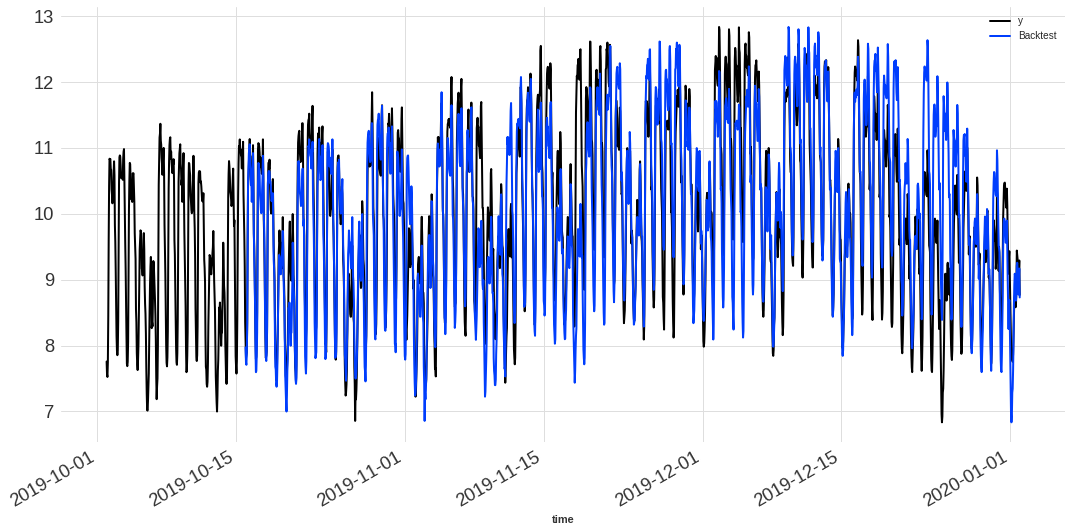

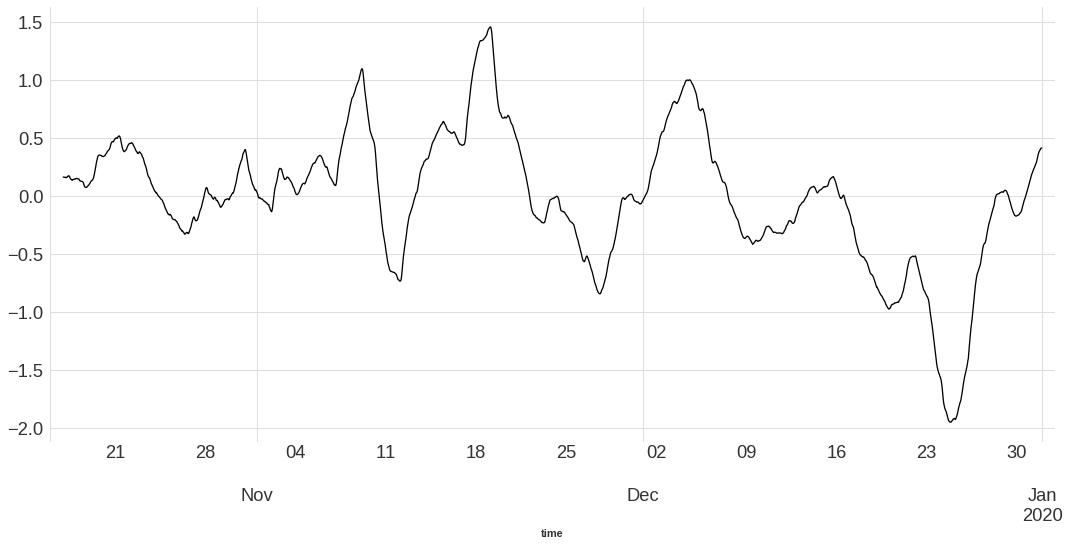

In [10]:
naive_model_weekly = NaiveSeasonal(K=168)
eval_model(naive_model_weekly, retrain=True)


In [11]:
naive_model_daily = NaiveSeasonal(K=24)
eval_model(naive_model_daily, retrain=True)


In [12]:
theta_model = Theta(seasonality_period=168)
eval_model(theta_model, retrain=True)


  0%|          | 0/1873 [00:00<?, ?it/s]

Backtest MAPE = 4.104554845548551


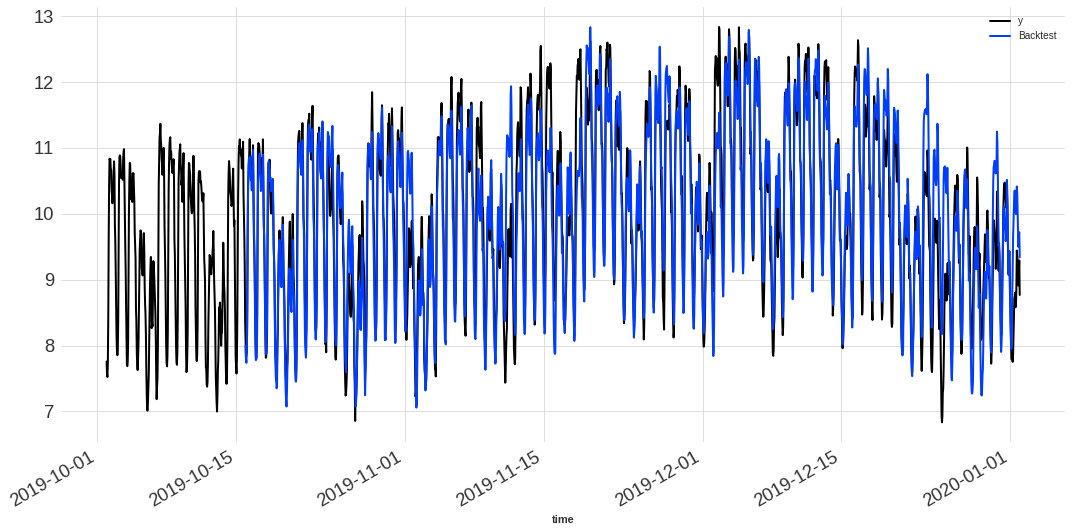

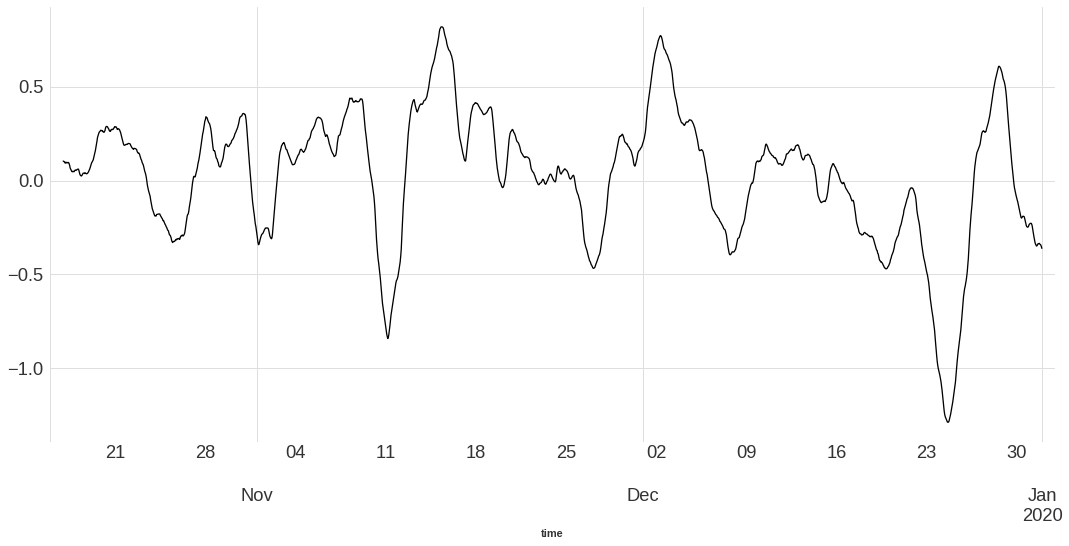

In [14]:
regr_model_lags = RegressionModel(lags=list(range(-672,0)))
regr_model_lags.fit(input_train)
eval_model(regr_model_lags, retrain=False)


In [15]:
future = TimeSeries.from_dataframe(data, value_cols=['Temperature', 'Day_of_week', 'Hour_of_day', 'Holidays'])

regr_model_cov_24 = RegressionModel(lags=list(range(-24,0)),
                                 lags_future_covariates=list(range(72)))

regr_model_cov_24.fit(input_train, 
                   future_covariates=future)

eval_model(regr_model_cov_24, retrain=False)


In [16]:
future = TimeSeries.from_dataframe(data, value_cols=['Temperature', 'Day_of_week', 'Hour_of_day', 'Holidays'])

regr_model_cov_168 = RegressionModel(lags=list(range(-168,0)),
                                 lags_future_covariates=list(range(72)))

regr_model_cov_168.fit(input_train, 
                   future_covariates=future)

eval_model(regr_model_cov_168, retrain=False)


In [23]:
future = TimeSeries.from_dataframe(data, value_cols=['Temperature', 'Day_of_week', 'Hour_of_day', 'Holidays'])

regr_model_cov = RegressionModel(lags=list(range(-672,0)),
                                 lags_future_covariates=list(range(72)))

regr_model_cov.fit(input_train, 
                   future_covariates=future)

# eval_model(regr_model_cov, retrain=False)


In [18]:
future = TimeSeries.from_dataframe(data, value_cols=['Day_of_week', 'Hour_of_day'])

regr_model_cov_timedate = RegressionModel(lags=list(range(-672,0)),
                                 lags_future_covariates=list(range(72)))

regr_model_cov_timedate.fit(input_train, 
                   future_covariates=future)

eval_model(regr_model_cov_timedate, retrain=False)

In [19]:
future = TimeSeries.from_dataframe(data, value_cols=['Temperature', 'Day_of_week', 'Hour_of_day', 'Holidays'])

regr_model_cov_ridge = RegressionModel(lags=list(range(-672,0)),
                                       lags_future_covariates=list(range(72)),
                                       model=sklearn.linear_model.Ridge(alpha=.01))

regr_model_cov_ridge.fit(input_train, 
                         future_covariates=future)

# eval_model(regr_model_cov_ridge, retrain=False)

In [20]:
future = TimeSeries.from_dataframe(data, value_cols=['Temperature', 'Day_of_week', 'Hour_of_day', 'Holidays'])

regr_model_cov_lasso = RegressionModel(lags=list(range(-672,0)),
                                       lags_future_covariates=list(range(72)),
                                       model=sklearn.linear_model.Lasso(alpha=.01))

regr_model_cov_lasso.fit(input_train, 
                         future_covariates=future)

# eval_model(regr_model_cov_lasso, retrain=False)

In [21]:
future = TimeSeries.from_dataframe(data, value_cols=['Smoothed_temperature', 'Day_of_week', 'Hour_of_day', 'Holidays'])

regr_model_cov_lgbm = LightGBMModel(lags=list(range(-672,0)),
                               lags_future_covariates=list(range(72)),
                               output_chunk_length=24)

regr_model_cov_lgbm.fit(input_train, 
                   future_covariates=future)

# eval_model(regr_model_cov_lgbm, retrain=False)


[LightGBM] [Warning] Unknown parameter: output_chunk_length


In [109]:
def get_historical_forecasts(model, model_display_name, future_covs=False, to_retrain=False):

    horizon = 72
    
    if future_covs == False:
        #print(model_display_name, 'no future_covs')
        forecast = model.historical_forecasts(input_timeseries,
                                              forecast_horizon=horizon, stride=24, verbose=True, 
                                              retrain = to_retrain,
                                              start=.33, last_points_only=False, overlap_end=False)
    else:
        #print(model_display_name, 'with future_covs')
        forecast = model.historical_forecasts(input_timeseries,
                                              forecast_horizon=horizon, stride=24, verbose=True,
                                              future_covariates=future, overlap_end=False,
                                              retrain = to_retrain,
                                              start=.33, last_points_only=False)
        
    res_df = pd.DataFrame()

    for i in range(len(forecast)):
        pred_df = forecast[i].pd_dataframe()
        pred_df['prediction_date'] = forecast[i].get_timestamp_at_point(0)
        pred_df['model'] = model_display_name
        pred_df.reset_index(inplace=True)
        pred_df.columns = ['ts','value','prediction_date','model']
        res_df = res_df.append(pred_df)
    
    if future_covs == False:
        return res_df.iloc[:-horizon]
    else:
        return res_df


models = {
    'Naive weekly':[naive_model_weekly,False,True],
    'Naive daily': [naive_model_daily,False,True],
    'Theta': [theta_model,False,True],
    'RegLags':[regr_model_lags,False,False],
    'RegCov672':[regr_model_cov,True,False],
    'RegCovLasso':[regr_model_cov_lasso,True,False],
    'RegCovRidge':[regr_model_cov_ridge,True,False],
    'RegCov24':[regr_model_cov_24,True,False],
    'RegCov168':[regr_model_cov_168,True,False],
    'RegCovLGBM':[regr_model_cov_lgbm,True,False]
#     'RegressionModelCovTimeDate':[regr_model_cov_timedate,True]
         }

optimization_df = pd.DataFrame()

import time



runtime_df = pd.DataFrame(index=models.keys(),columns=['runtime'])

for model in models.keys():
    print(model)
    start=time.time()
    optimization_df = optimization_df.append(get_historical_forecasts(model = models[model][0],
                                                                      model_display_name = model,
                                                                      future_covs = models[model][1],
                                                                      to_retrain=models[model][2]))
    end = time.time()
    runtime_df.loc[model,'runtime'] = (end-start)
    

Naive weekly


  0%|          | 0/487 [00:00<?, ?it/s]

Naive daily


  0%|          | 0/487 [00:00<?, ?it/s]

Theta


  0%|          | 0/487 [00:00<?, ?it/s]

RegLags


  0%|          | 0/487 [00:00<?, ?it/s]

RegCov672


  0%|          | 0/484 [00:00<?, ?it/s]

RegCovLasso


  0%|          | 0/484 [00:00<?, ?it/s]

RegCovRidge


  0%|          | 0/484 [00:00<?, ?it/s]

RegCov24


  0%|          | 0/484 [00:00<?, ?it/s]

RegCov168


  0%|          | 0/484 [00:00<?, ?it/s]

RegCovLGBM


  0%|          | 0/484 [00:00<?, ?it/s]

In [110]:
optimization_df

,ts,value,prediction_date,model
0,2018-08-30 05:00:00,9.925000,2018-08-30 05:00:00,Naive weekly
1,2018-08-30 06:00:00,10.502500,2018-08-30 05:00:00,Naive weekly
2,2018-08-30 07:00:00,10.877000,2018-08-30 05:00:00,Naive weekly
3,2018-08-30 08:00:00,11.007000,2018-08-30 05:00:00,Naive weekly
4,2018-08-30 09:00:00,11.073000,2018-08-30 05:00:00,Naive weekly
...,...,...,...,...
67,2019-12-29 00:00:00,7.926815,2019-12-26 05:00:00,RegCovLGBM
68,2019-12-29 01:00:00,7.624683,2019-12-26 05:00:00,RegCovLGBM
69,2019-12-29 02:00:00,7.477111,2019-12-26 05:00:00,RegCovLGBM
70,2019-12-29 03:00:00,7.370562,2019-12-26 05:00:00,RegCovLGBM


In [111]:
# optimization_df[optimization_df.model=='Naive weekly'].value.plot()

In [112]:
runtime_df

,runtime
Naive weekly,6.013794
Naive daily,6.106791
Theta,66.291347
RegLags,12.189211
RegCov672,14.212194
RegCovLasso,14.400993
RegCovRidge,14.056195
RegCov24,11.586331
RegCov168,12.416652
RegCovLGBM,35.61873


In [113]:
fact = optimization_df.loc[optimization_df.model=='Naive weekly'].copy()#.join('tmp.y.loc[optimization_df.index]')
fact.set_index('ts', inplace=True)
fact['model'] = 'Fact'
fact['value'] = data.y.loc[fact.index]
fact.reset_index(inplace=True)

if len(optimization_df.loc[optimization_df.model=='Fact'])==0:
    optimization_df = optimization_df.append(fact)


# tmp = optimization_df.groupby(['ts','prediction_date']).mean().reset_index()
# tmp['model'] = 'mean_of_all_models'
# optimization_df = optimization_df.append(tmp)

# tmp = optimization_df.groupby(['ts','prediction_date']).median().reset_index()
# tmp['model'] = 'median_of_all_models'
# optimization_df = optimization_df.append(tmp)

# tmp = optimization_df.groupby(['ts','prediction_date']).quantile(.05).reset_index()
# tmp['model'] = '5p_of_all_models'
# optimization_df = optimization_df.append(tmp)

# tmp = optimization_df.groupby(['ts','prediction_date']).quantile(.25).reset_index()
# tmp['model'] = '25p_of_all_models'
# optimization_df = optimization_df.append(tmp)

# tmp = optimization_df.groupby(['ts','prediction_date']).quantile(.75).reset_index()
# tmp['model'] = '75p_of_all_models'
# optimization_df = optimization_df.append(tmp)

# tmp= optimization_df.groupby(['ts','prediction_date']).quantile(.95).reset_index()
# tmp['model'] = '95p_of_all_models'
# optimization_df = optimization_df.append(tmp)

# optimization_df.set_index('ts', inplace=True)

In [122]:
noisy_biased_1p = fact.copy()
noisy_biased_1p.model = 'noisy_biased_1p'
noisy_biased_1p.value = fact.value + 1

noisy_biased_2p = fact.copy()
noisy_biased_2p.model = 'noisy_biased_2p'
noisy_biased_2p.value = fact.value + 2

noisy_biased_3p = fact.copy()
noisy_biased_3p.model = 'noisy_biased_3p'
noisy_biased_3p.value = fact.value + 3

noisy_biased_4p = fact.copy()
noisy_biased_4p.model = 'noisy_biased_4p'
noisy_biased_4p.value = fact.value + 4

noisy_biased_1n = fact.copy()
noisy_biased_1n.model = 'noisy_biased_1n'
noisy_biased_1n.value = fact.value - 1

noisy_biased_2n = fact.copy()
noisy_biased_2n.model = 'noisy_biased_2n'
noisy_biased_2n.value = fact.value - 2

noisy_biased_3n = fact.copy()
noisy_biased_3n.model = 'noisy_biased_3n'
noisy_biased_3n.value = fact.value - 3

noisy_biased_4n = fact.copy()
noisy_biased_4n.model = 'noisy_biased_4n'
noisy_biased_4n.value = fact.value - 4

optimization_df = optimization_df.append(noisy_biased_1p)
optimization_df = optimization_df.append(noisy_biased_2p)
optimization_df = optimization_df.append(noisy_biased_3p)
optimization_df = optimization_df.append(noisy_biased_4p)
optimization_df = optimization_df.append(noisy_biased_1n)
optimization_df = optimization_df.append(noisy_biased_2n)
optimization_df = optimization_df.append(noisy_biased_3n)
optimization_df = optimization_df.append(noisy_biased_4n)


In [123]:
np.random.seed(42)

noisy_normal_0u_1s = fact.copy()
noisy_normal_0u_1s.model = 'noisy_normal_0u_1s'
noisy_normal_0u_1s.value = fact.value + np.random.uniform(-1,1,len(fact))

noisy_normal_0u_2s = fact.copy()
noisy_normal_0u_2s.model = 'noisy_normal_0u_2s'
noisy_normal_0u_2s.value = fact.value + np.random.uniform(-2,2,len(fact))

noisy_normal_0u_3s = fact.copy()
noisy_normal_0u_3s.model = 'noisy_normal_0u_3s'
noisy_normal_0u_3s.value = fact.value + np.random.uniform(-3,3,len(fact))

noisy_normal_0u_4s = fact.copy()
noisy_normal_0u_4s.model = 'noisy_normal_0u_4s'
noisy_normal_0u_4s.value = fact.value + np.random.uniform(-4,4,len(fact))

optimization_df = optimization_df.append(noisy_normal_0u_1s)
optimization_df = optimization_df.append(noisy_normal_0u_2s)
optimization_df = optimization_df.append(noisy_normal_0u_3s)
optimization_df = optimization_df.append(noisy_normal_0u_4s)


In [124]:
np.random.seed(42)

noisy_signal_dependent_10 = fact.copy()
noisy_signal_dependent_10.model = 'noisy_signal_dependent_10'
noisy_signal_dependent_10.value = fact.value + fact.value * .1 * np.random.uniform(-1,1,len(fact))

noisy_signal_dependent_20 = fact.copy()
noisy_signal_dependent_20.model = 'noisy_signal_dependent_20'
noisy_signal_dependent_20.value = fact.value + fact.value * .2 * np.random.uniform(-1,1,len(fact))

noisy_signal_dependent_30 = fact.copy()
noisy_signal_dependent_30.model = 'noisy_signal_dependent_30'
noisy_signal_dependent_30.value = fact.value + fact.value * .3 * np.random.uniform(-1,1,len(fact))

noisy_signal_dependent_40 = fact.copy()
noisy_signal_dependent_40.model = 'noisy_signal_dependent_40'
noisy_signal_dependent_40.value = fact.value + fact.value * .4 * np.random.uniform(-1,1,len(fact))

optimization_df = optimization_df.append(noisy_signal_dependent_10)
optimization_df = optimization_df.append(noisy_signal_dependent_20)
optimization_df = optimization_df.append(noisy_signal_dependent_30)
optimization_df = optimization_df.append(noisy_signal_dependent_40)

In [125]:
fact['time_since_prediction'] = (fact.ts - fact.prediction_date) / np.timedelta64(1, 'h')
fact

,ts,value,prediction_date,model,time_since_prediction
0,2018-08-30 05:00:00,10.192250,2018-08-30 05:00:00,Fact,0.0
1,2018-08-30 06:00:00,10.805000,2018-08-30 05:00:00,Fact,1.0
2,2018-08-30 07:00:00,11.028000,2018-08-30 05:00:00,Fact,2.0
3,2018-08-30 08:00:00,11.140667,2018-08-30 05:00:00,Fact,3.0
4,2018-08-30 09:00:00,11.225000,2018-08-30 05:00:00,Fact,4.0
...,...,...,...,...,...
34987,2019-12-31 00:00:00,8.633250,2019-12-28 05:00:00,Fact,67.0
34988,2019-12-31 01:00:00,8.368000,2019-12-28 05:00:00,Fact,68.0
34989,2019-12-31 02:00:00,8.170667,2019-12-28 05:00:00,Fact,69.0
34990,2019-12-31 03:00:00,8.168667,2019-12-28 05:00:00,Fact,70.0


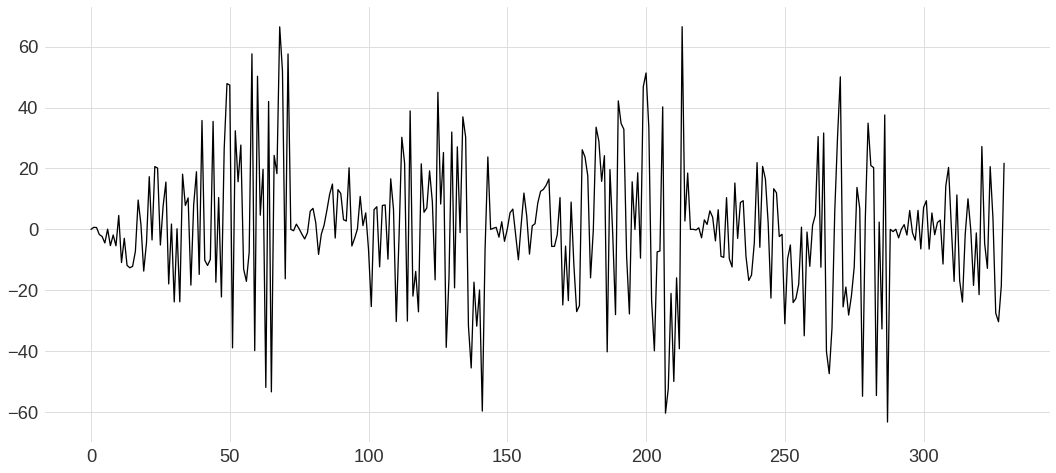

In [126]:
plt.plot(np.random.uniform(-fact.time_since_prediction,fact.time_since_prediction,len(fact))[0:330])

In [127]:
np.random.seed(42)

noisy_horizon_dependent_10 = fact.copy()
noisy_horizon_dependent_10.model = 'noisy_horizon_dependent_10'
noisy_horizon_dependent_10.value = fact.value + fact.value * .1 * np.random.uniform(-1,1,len(fact))

noisy_horizon_dependent_20 = fact.copy()
noisy_horizon_dependent_20.model = 'noisy_horizon_dependent_20'
noisy_horizon_dependent_20.value = fact.value + fact.value * .2 * np.random.uniform(-1,1,len(fact))

noisy_horizon_dependent_30 = fact.copy()
noisy_horizon_dependent_30.model = 'noisy_horizon_dependent_30'
noisy_horizon_dependent_30.value = fact.value + fact.value * .3 * np.random.uniform(-1,1,len(fact))

noisy_horizon_dependent_40 = fact.copy()
noisy_horizon_dependent_40.model = 'noisy_horizon_dependent_40'
noisy_horizon_dependent_40.value = fact.value + fact.value * .4 * np.random.uniform(-1,1,len(fact))

optimization_df = optimization_df.append(noisy_horizon_dependent_10)
optimization_df = optimization_df.append(noisy_horizon_dependent_20)
optimization_df = optimization_df.append(noisy_horizon_dependent_30)
optimization_df = optimization_df.append(noisy_horizon_dependent_40)

In [128]:
optimization_df

,ts,value,prediction_date,model,time_since_prediction
0,2018-08-30 05:00:00,9.925000,2018-08-30 05:00:00,Naive weekly,NaN
1,2018-08-30 06:00:00,10.502500,2018-08-30 05:00:00,Naive weekly,NaN
2,2018-08-30 07:00:00,10.877000,2018-08-30 05:00:00,Naive weekly,NaN
3,2018-08-30 08:00:00,11.007000,2018-08-30 05:00:00,Naive weekly,NaN
4,2018-08-30 09:00:00,11.073000,2018-08-30 05:00:00,Naive weekly,NaN
...,...,...,...,...,...
34987,2019-12-31 00:00:00,9.625257,2019-12-28 05:00:00,noisy_horizon_dependent_40,67.0
34988,2019-12-31 01:00:00,10.859923,2019-12-28 05:00:00,noisy_horizon_dependent_40,68.0
34989,2019-12-31 02:00:00,10.900722,2019-12-28 05:00:00,noisy_horizon_dependent_40,69.0
34990,2019-12-31 03:00:00,9.331254,2019-12-28 05:00:00,noisy_horizon_dependent_40,70.0


In [ ]:
alt.data_transformers.disable_max_rows()

alt.Chart(optimization_df.reset_index()).mark_line().encode(
    x='ts:T',
    y=alt.Y('value:Q',scale=alt.Scale(zero=False)),
    color=alt.Color('prediction_date:N', legend=None),
    row='model:N'
).properties(width=600, height=150).interactive()


# Optimizer to choose from several predictions

Predictions are ready. Now we are creating a child class for Electricity Peak Case. 
We need the child class to pass there task-specific cost functions and other constant values like PEAK_POWER_LIMIT, BATTERY_CHARGE, BATTERY_CAPACITY end so on

In [114]:
# !pip install pulp
import pulp

In [115]:
def formulate_optimization_problem(price, demand, inverterCapacity, batteryCapacity, batteryInitialCharge, peakPowerLimit):
    
    # Create a list of time points when decision needs to be taken
    time_points=[str(i) for i in range(len(demand))]
    
    # Create dictionary holding prices at the time points
    price_dict = dict(zip(time_points, price))

    # Create a variable for every point in time
    time_point_vars=pulp.LpVariable.dict("solution",time_points,-inverterCapacity,inverterCapacity)

    # Define the problem as minimization
    prob = pulp.LpProblem("VOF", pulp.LpMinimize)
    prob += pulp.lpSum([time_point_vars[i]*price_dict[i] for i in time_points])
    
    # Create a variable for every point in time
    demand_vars=dict(zip(time_points, demand))

    # Add constraints
    prob += time_point_vars['0'] == batteryInitialCharge
    for j in range(len(time_points)):
        # At every point in time the cumulated charge/discharge needs to be within bounds
        prob += pulp.lpSum([time_point_vars[i] for i in time_points[:j+1]]) <= batteryCapacity
        prob += pulp.lpSum([time_point_vars[i] for i in time_points[:j+1]]) >= 0
        prob += time_point_vars[str(j)] + demand_vars[str(j)] >= 0
        prob += time_point_vars[str(j)] + demand_vars[str(j)] <= peakPowerLimit
        
#     print(prob)
    return prob
    

In [116]:
def evaluate_optimization_problem(price, demand, peakPowerLimit):
    peakViolations = 0    
    peakViolations += np.sum((solution+actualDemand.values)[0:24] - peakPowerLimit)
    
    print(peakViolations)

In [117]:
optimization_df.model.unique()

array(['Naive weekly', 'Naive daily', 'Theta', 'RegLags', 'RegCov672',
       'RegCovLasso', 'RegCovRidge', 'RegCov24', 'RegCov168',
       'RegCovLGBM', 'Fact'], dtype=object)

In [124]:
batteryCapacity = 8.0 #kWh
inverterCapacity = 4.0 #kW
peakPowerLimit = 10 # kW

total_steps = optimization_df.prediction_date.unique()
# battery_ch = batteryInitialCharge
# model = 'Naive weekly'
# model = 'RegressionModelCov'
actualModel = 'Fact'
peakViolations = np.zeros(1+len(optimization_df.model.unique()))
predictionError = np.zeros(1+len(optimization_df.model.unique()))
predictionErrorFirstDay = np.zeros(1+len(optimization_df.model.unique()))

ctr = 0
for model in optimization_df.model.unique():
# for model in ['Naive daily']:
    
    print(model)
    peakViolations[ctr] = 0
    batteryInitialCharge = 0 #kWh

    for step in total_steps[0:30]:
#         print(step)

        demand = optimization_df.loc[(optimization_df.prediction_date==step)&(optimization_df.model==model),'value']
        actualDemand = optimization_df.loc[(optimization_df.prediction_date==step)&(optimization_df.model==actualModel),'value']

        price = np.ones(len(demand))

        opt_problem = formulate_optimization_problem(price, demand, inverterCapacity, batteryCapacity, batteryInitialCharge, peakPowerLimit)
        opt_problem.solve()

#         print("Found minimum",opt_problem.objective.value())

        solution_dict = {}
        for v in opt_problem.variables():
            solution_dict[int(v.name.replace("solution_",""))] = v.varValue
        # Now convert solution dictionary to a time-sorted list
        solution=[]
        for i in sorted (solution_dict) :
            solution.append(solution_dict[i])

#         batteryInitialCharge = np.cumsum(solution)[23]
#         print(np.cumsum(solution)[23])
#         plt.plot(solution,label='Solution')
#         plt.plot(demand.values,label='Predicted demand')
#         plt.plot(actualDemand.values,label='Actual demand')
#         plt.plot(solution+demand.values,label='Sol+Pred.Demand')
#         plt.plot(solution+actualDemand.values,label='Sol+Act.Demand')
#         plt.legend()
#         plt.show()

#         peakViolations[ctr] += np.sum((solution+actualDemand.values)[0:24] - peakPowerLimit)
        excessDemand = (solution+actualDemand.values)[0:24]-peakPowerLimit
        peakViolations[ctr] += np.sum(excessDemand[excessDemand>0])
        predictionError[ctr] += np.nanmean(np.abs(demand.values-actualDemand.values))
        predictionErrorFirstDay[ctr] += np.nanmean(np.abs(demand.values[0:24]-actualDemand.values[0:24]))
    

    print(predictionError[ctr], predictionErrorFirstDay[ctr], peakViolations[ctr])
    ctr += 1


Naive weekly
5.892381944444445 5.805222222222222 378.22087467333336
Naive daily
23.469971064814814 14.961854166666665 431.78683326633336
Theta
14.109255430524366 13.170203366031 498.03411302800004
RegLags
5.2937252422629095 4.683686323405566 370.21959727399997
RegCov672
4.79492756539804 4.161365687052408 367.2866181433334
RegCovLasso
5.72634332752365 4.913207642047534 364.54967047300005
RegCovRidge
4.794281954305825 4.160916491697255 367.26892440833325
RegCov24
7.483061336446693 6.551682242075602 375.05355386103327
RegCov168
5.1301178207750695 4.4429704895019535 365.8651026383333
RegCovLGBM
4.5067674618523235 3.9026309254510907 371.35879483433337
Fact
0.0 0.0 328.73479216700014


In [58]:
for step in total_steps[0:30]:

    actualDemand = optimization_df.loc[(optimization_df.prediction_date==step)&(optimization_df.model==actualModel),'value']
    excessDemand = (actualDemand.values)-peakPowerLimit
    peakViolations[ctr] += np.sum(excessDemand[excessDemand>0])
    predictionError[ctr] = 0
    predictionErrorFirstDay[ctr] = 0


In [119]:
peakViolations

array([131.22058314, 151.15987509,  63.3559534 , 110.73300715,
        71.05535624, 126.23383069,  71.10357688,  86.06476006,
        74.42014926, 115.32777464,  52.81341791,   0.        ])

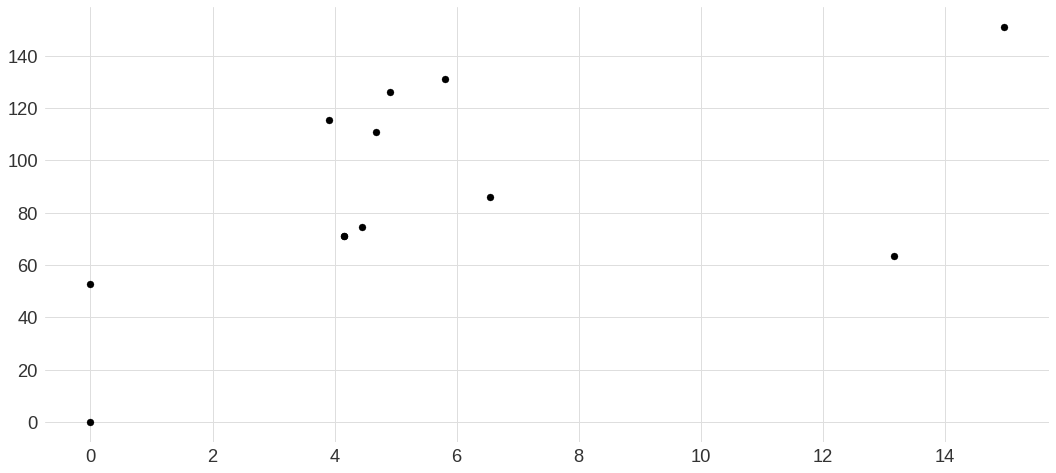

In [120]:
plt.scatter(predictionErrorFirstDay, peakViolations)


In [125]:
model_names = optimization_df.model.unique()
model_names = np.hstack((model_names, ['No control']))


In [126]:
results_df = pd.DataFrame(np.array([model_names, predictionErrorFirstDay, peakViolations]).T).iloc[:-1,:]
results_df.columns = ['Model', 'Forecast error', 'Downstream costs']
results_df


,Model,Forecast error,Downstream costs
0,Naive weekly,5.805222,378.220875
1,Naive daily,14.961854,431.786833
2,Theta,13.170203,498.034113
3,RegLags,4.683686,370.219597
4,RegCov672,4.161366,367.286618
5,RegCovLasso,4.913208,364.54967
6,RegCovRidge,4.160916,367.268924
7,RegCov24,6.551682,375.053554
8,RegCov168,4.44297,365.865103
9,RegCovLGBM,3.902631,371.358795


In [76]:
results_df = pd.DataFrame(np.array([model_names, predictionErrorFirstDay, peakViolations]).T)
results_df.columns = ['Model', 'Forecast error', 'Downstream costs']
results_df


,Model,Forecast error,Downstream costs
0,Naive weekly,5.805222,378.220875
1,Naive daily,14.961854,431.786833
2,Theta,13.170203,498.034113
3,RegressionModelLags,4.683686,370.219597
4,RegressionModelCov672,4.161366,367.286618
5,RegressionModelCovLasso,4.913208,364.54967
6,RegressionModelCovRidge,4.160916,367.268924
7,RegressionModelCov24,6.551682,375.053554
8,RegressionModelCov168,4.44297,365.865103
9,RegressionModelCovLGBM,3.902631,371.358795


In [123]:
chart = alt.Chart(results_df).mark_circle(size=500).encode(
    x='Forecast error:Q',
    y = alt.Y('Downstream costs:Q', scale=alt.Scale(domain=[0, 160])),
#     y=alt.Y('Downstream costs:Q'),
    color=alt.Color('Model:N'),
    tooltip = ['Model:N','Forecast error:Q','Downstream costs:Q']
).properties(width=800, height=600)

chart2 = alt.Chart(results_df).mark_circle(size=500).encode(
    x='Forecast error:Q',
    y=alt.Y('Downstream costs:Q'),
    color=alt.Color('Model:N'),
    tooltip = ['Model:N','Forecast error:Q','Downstream costs:Q']
).properties(width=800, height=600)

(chart + chart2 + chart.transform_loess('Forecast error', 'Downstream costs', bandwidth=.99).mark_line()).configure_axis(
    labelFontSize=20,
    titleFontSize=20
).configure_legend(
titleFontSize=18,
labelFontSize=15
) 

# chart +chart2+ chart.transform_regression('Forecast error', 'Downstream costs', method='poly', order=3).mark_line()


alt.LayerChart(...)

In [128]:
chart = alt.Chart(results_df).mark_circle(size=500).encode(
    x='Forecast error:Q',
    y = alt.Y('Downstream costs:Q', scale=alt.Scale(domain=[300, 520])),
#     y=alt.Y('Downstream costs:Q'),
    color=alt.Color('Model:N'),
    tooltip = ['Model:N','Forecast error:Q','Downstream costs:Q']
).properties(width=800, height=600)

chart2 = alt.Chart(results_df).mark_circle(size=500).encode(
    x='Forecast error:Q',
    y=alt.Y('Downstream costs:Q'),
    color=alt.Color('Model:N'),
    tooltip = ['Model:N','Forecast error:Q','Downstream costs:Q']
).properties(width=800, height=600)

(chart + chart2 + chart.transform_loess('Forecast error', 'Downstream costs', bandwidth=.99).mark_line()).configure_axis(
    labelFontSize=20,
    titleFontSize=20
).configure_legend(
titleFontSize=18,
labelFontSize=15
) 

# chart +chart2+ chart.transform_regression('Forecast error', 'Downstream costs', method='poly', order=3).mark_line()


alt.LayerChart(...)

In [102]:
np.abs(demand-actualDemand)

648    0.0
649    0.0
650    0.0
651    0.0
652    0.0
653    0.0
654    0.0
655    0.0
656    0.0
657    0.0
658    0.0
659    0.0
660    0.0
661    0.0
662    0.0
663    0.0
664    0.0
665    0.0
666    0.0
667    0.0
668    0.0
669    0.0
670    0.0
671    0.0
672    0.0
673    0.0
674    0.0
675    0.0
676    0.0
677    0.0
678    0.0
679    0.0
680    0.0
681    0.0
682    0.0
683    0.0
684    0.0
685    0.0
686    0.0
687    0.0
688    0.0
689    0.0
690    0.0
691    0.0
692    0.0
693    0.0
694    0.0
695    0.0
696    0.0
697    0.0
698    0.0
699    0.0
700    0.0
701    0.0
702    0.0
703    0.0
704    0.0
705    0.0
706    0.0
707    0.0
708    0.0
709    0.0
710    0.0
711    0.0
712    0.0
713    0.0
714    0.0
715    0.0
716    0.0
717    0.0
718    0.0
719    0.0
Name: value, dtype: float64

In [ ]:
# Create a list of time points when decision needs to be taken
control_horizon = 72
control_update_step = 24
time_points=[str(i) for i in range(control_horizon)]

# Create dictionary holding prices at the time points
price_dict = dict(zip(time_points, price[0:control_horizon]))

# Create a variable for every point in time
time_point_vars=pulp.LpVariable.dict("solution",time_points,-inverterCapacity,inverterCapacity)

# Define the problem as minimization
prob = pulp.LpProblem("VOF", pulp.LpMinimize)
prob += pulp.lpSum([time_point_vars[i]*price_dict[i] for i in time_points])

# Add constraints
prob += time_point_vars['0'] == 20
for j in range(len(time_points)):
    # At every point in time the cumulated charge/discharge needs to be within bounds
    prob += pulp.lpSum([time_point_vars[i] for i in time_points[:j+1]]) <= batteryCapacity
    prob += pulp.lpSum([time_point_vars[i] for i in time_points[:j+1]]) >= 0
    prob += time_point_vars[str(j)] + demand_vars[str(j)] >= 0
    prob += time_point_vars[str(j)] + demand_vars[str(j)] <= 80


In [ ]:
def calculate_optimal_decision(self, model):
    EVALUATE = False
    TIME_HORIZON = 72#168
    DECISION_TIMESTEP = 24
    PEAK_POWER_LIMIT = 11
    BATTERY_CHARGE = 0
    BATTERY_CAPACITY = 1000
    BATTERY_EFFICIENCY = .99
    INVERTER_CAPACITY = 80
    

In [ ]:
# Solve
prob.solve()
# Print result
print("Found minimum",prob.objective.value())
solution_dict = {}
for v in prob.variables():
    solution_dict[int(v.name.replace("solution_",""))] = v.varValue
# Now convert solution dictionary to a time-sorted list
solution=[]
for i in sorted (solution_dict) :
    solution.append(solution_dict[i])

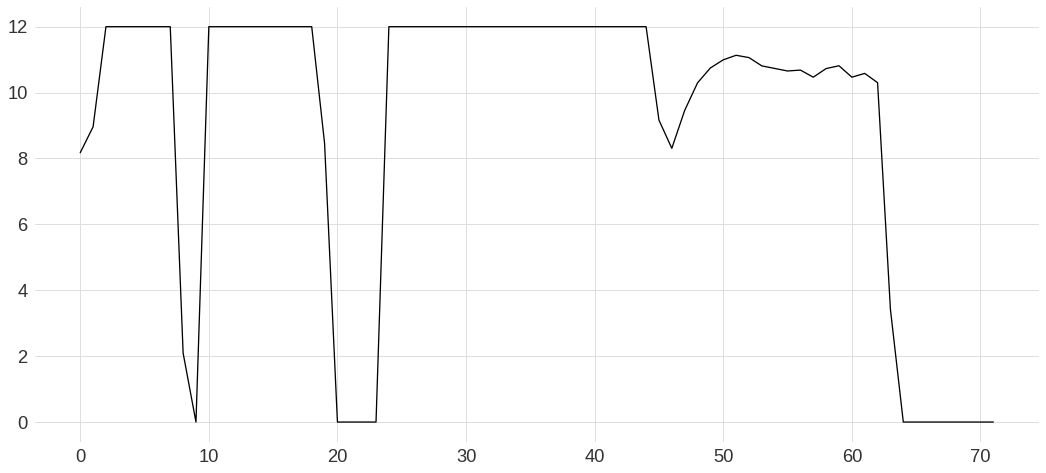

In [78]:
plt.plot(solution+actualDemand.values)

In [70]:
optimization_df.model.unique()

array(['Naive weekly', 'Naive daily', 'RegressionModelCov', 'Fact',
       'noisy_biased_1p', 'noisy_biased_2p', 'noisy_biased_3p',
       'noisy_biased_4p', 'noisy_biased_1n', 'noisy_biased_2n',
       'noisy_biased_3n', 'noisy_biased_4n'], dtype=object)

In [97]:
np.sum((solution+actualDemand.values)[0:24] - peakPowerLimit)

-80.30941681766667

In [99]:
peakViolations

array([-2.38543333e+01, -1.84165833e+01,  1.71947920e-01,  4.38809210e-01,
        4.71879503e-01, -2.09972340e-01, -2.93720937e-01, -2.66795794e+00,
       -3.27596032e+01, -7.48815988e+01, -2.02270510e+00, -4.21464267e-01,
       -4.57391200e-01,  4.59642333e-02, -3.49436500e-01, -3.95372867e-01,
       -6.21076500e-01, -5.96502233e-01, -5.97171867e-01, -8.13607522e+00,
       -3.63755960e+01, -3.59905404e+01, -3.56069990e+01, -2.30813377e+01])

In [ ]:
# Print result
print("Found minimum",opt_problem.objective.value())
solution_dict = {}
for v in opt_problem.variables():
    solution_dict[int(v.name.replace("solution_",""))] = v.varValue
# Now convert solution dictionary to a time-sorted list
solution=[]
for i in sorted (solution_dict) :
    solution.append(solution_dict[i])
# visualizeResults(solution)
plt.plot(solution)


In [ ]:
def calculate_optimal_decision(model):
        
    print(model)

    total_steps = optimization_df.prediction_date.unique()

#     recommendation = np.array([])
#     recommendation = pd.Series()
    battery_ch = self.BATTERY_CHARGE

    for step in total_steps:
        print(step)
#         par = ng.p.Array(shape=(self.TIME_HORIZON,)).set_bounds(lower=-self.INVERTER_CAPACITY, upper=self.INVERTER_CAPACITY)
#         instru = ng.p.Instrumentation(par,battery_ch)
#         optimizer = ng.optimizers.CMA(parametrization=instru, budget=2500)
        
        

        try:
            self.candidate = self.data.loc[(self.data.prediction_date==step)&(self.data.model==model),'value']
        except:
            #print(self.optimal_decisions_df.shape)
            print(self.data.loc[(self.data.prediction_date==step)&(self.data.model==model),'value'])


        step_recommendation = optimizer.minimize(self.cost_function)

        #because step_recommendation returns a tuple, we need to access element with index [0][0]:           
        #recommendation = np.append(recommendation,step_recommendation[0][0].value[0:self.DECISION_TIMESTEP])

        recommendation = recommendation.append(pd.Series(data=step_recommendation[0][0].value[0:self.DECISION_TIMESTEP],
                                                         index=np.array(self.data.loc[(self.data.prediction_date==step)&(self.data.model==model),'value'].iloc[0:self.DECISION_TIMESTEP].index)))
        battery_ch += sum(step_recommendation[0][0].value[0:self.DECISION_TIMESTEP])

    return pd.Series(name=model, data=recommendation)


def select_value_optimal_model(self,models,return_predictions=False):

    random.seed(42)

    #self.optimal_decisions_df = pd.DataFrame(index=(self.x.index),columns=self.x.columns).iloc[:-self.TIME_HORIZON]

    #parallel_optimal_decision_result = (Parallel(n_jobs=-1, verbose = 1000)(delayed(self.calculate_optimal_decision)(col) for col in range(len(self.optimal_decisions_df.columns))))

    self.optimal_decision_result = (Parallel(n_jobs=-1, verbose = 1000)(delayed(self.calculate_optimal_decision)(model) for model in models))


    #for i in parallel_optimal_decision_result:
    #    self.optimal_decisions_df.iloc[:,i.name] = i.values

    return self.optimal_decision_result#self.optimal_decisions_df

In [53]:
class OptimalDecisionMakersElectricityPeak(optimizer.OptimalDecisionMakers):
    
    def __init__(self, data, target):
        super().__init__(data, target)
        self.EVALUATE = False
        self.TIME_HORIZON = 72#168
        self.DECISION_TIMESTEP = 24
        self.PEAK_POWER_LIMIT = 11
        self.BATTERY_CHARGE = 0
        self.BATTERY_CAPACITY = 1000
        self.BATTERY_EFFICIENCY = .99
        self.INVERTER_CAPACITY = 80
        
    def cost_function(self,solution,battery_charge):
        #print(battery_charge)
        cumsum = np.cumsum(solution) + battery_charge

        #battery capacity penalty:
        violations_battery = (np.sum(np.where(cumsum>self.BATTERY_CAPACITY)) + np.sum(np.where(cumsum<0))) * 10000
        
        
        #penalty for putting electricity back to the grid
        if self.EVALUATE:
            grid_load = (self.data.loc[self.data.model==target,'value']+solution).values
        else:
            #print(self.candidate.shape)
            grid_load = (self.candidate+solution).values
        
        violations_demand = -np.sum(grid_load[np.where(grid_load<0)]) * 10000

        #penlty for high peak in load
        margin = (self.PEAK_POWER_LIMIT - grid_load)
        violations_peak = -np.sum(margin[np.where(margin < 0)]) * 10000

        #penalty for battery losses
        battery_usage = (1 - self.BATTERY_EFFICIENCY) * np.sum(np.abs(solution)) * 1000

        total_cost = violations_battery + violations_demand + violations_peak + battery_usage
        return total_cost
    
        
    def calculate_optimal_decision(self, model):
        
        print(model)

        total_steps = self.data.prediction_date.unique()

        #recommendation = np.array([])
        recommendation = pd.Series()
        battery_ch = self.BATTERY_CHARGE

        for step in total_steps:
            print(step)
            par = ng.p.Array(shape=(self.TIME_HORIZON,)).set_bounds(lower=-self.INVERTER_CAPACITY, upper=self.INVERTER_CAPACITY)
            instru = ng.p.Instrumentation(par,battery_ch)
            optimizer = ng.optimizers.CMA(parametrization=instru, budget=2500)

            try:
                self.candidate = self.data.loc[(self.data.prediction_date==step)&(self.data.model==model),'value']
            except:
                #print(self.optimal_decisions_df.shape)
                print(self.data.loc[(self.data.prediction_date==step)&(self.data.model==model),'value'])


            step_recommendation = optimizer.minimize(self.cost_function)

            #because step_recommendation returns a tuple, we need to access element with index [0][0]:           
            #recommendation = np.append(recommendation,step_recommendation[0][0].value[0:self.DECISION_TIMESTEP])
            
            recommendation = recommendation.append(pd.Series(data=step_recommendation[0][0].value[0:self.DECISION_TIMESTEP],
                                                             index=np.array(self.data.loc[(self.data.prediction_date==step)&(self.data.model==model),'value'].iloc[0:self.DECISION_TIMESTEP].index)))
            battery_ch += sum(step_recommendation[0][0].value[0:self.DECISION_TIMESTEP])
        
        return pd.Series(name=model, data=recommendation)
    

    def select_value_optimal_model(self,models,return_predictions=False):
        
        random.seed(42)
        
        #self.optimal_decisions_df = pd.DataFrame(index=(self.x.index),columns=self.x.columns).iloc[:-self.TIME_HORIZON]
        
        #parallel_optimal_decision_result = (Parallel(n_jobs=-1, verbose = 1000)(delayed(self.calculate_optimal_decision)(col) for col in range(len(self.optimal_decisions_df.columns))))
        
        self.optimal_decision_result = (Parallel(n_jobs=-1, verbose = 1000)(delayed(self.calculate_optimal_decision)(model) for model in models))

                
        #for i in parallel_optimal_decision_result:
        #    self.optimal_decisions_df.iloc[:,i.name] = i.values

        return self.optimal_decision_result#self.optimal_decisions_df
    
    def evaluate(self):
        
        evaluation_df = pd.DataFrame(index=range(len(self.optimal_decision_result)), columns=['model','cost_evaluation','error_evaluation'])
        for i in range(len(self.optimal_decision_result)):  
            evaluation_df.loc[i,'model'] = self.optimal_decision_result[i].name
            evaluation_df.loc[i,'cost_evaluation'] = (self.optimal_decision_result[i]+self.data.loc[self.data.model=='Fact','value'])[(self.optimal_decision_result[i]+self.data.loc[self.data.model=='Fact','value'])>self.PEAK_POWER_LIMIT].sum()
            evaluation_df.loc[i,'error_evaluation'] = np.mean(np.abs(self.data.loc[self.data.model=='Fact','value'] - self.data.loc[self.data.model==self.optimal_decision_result[i].name,'value']))
            #print(evaluation_df)
            
        return evaluation_df
    
    def evaluate_no_control_case(self):
        evaluation_df = pd.DataFrame(index=[0])#index=range(len(self.optimal_decision_result)), columns=['model','cost_evaluation','error_evaluation'])
        evaluation_df['model'] = 'Fact (no control)'
        evaluation_df['cost_evaluation'] = (self.data.loc[self.data.model=='Fact','value'])[(self.data.loc[self.data.model=='Fact','value'])>self.PEAK_POWER_LIMIT].sum()
        evaluation_df['error_evaluation'] = 0
        
        return evaluation_df
        
    def select_value_optimal_hyperparameters():
        return
    

## Now just creating an oblect of this child class using optimization_df from the previous steps

In [54]:
odm = OptimalDecisionMakersElectricityPeak(optimization_df,'Fact')

In [55]:
#odm.calculate_optimal_decision('RegressionModelCov')
#optimization_df.model.value_counts()

## Running optimization to select the optimal model

In [56]:
sol = odm.select_value_optimal_model(models=optimization_df.model.unique())
#sol

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed: 20.4min remaining: 102.2min
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed: 20.5min remaining: 61.5min
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed: 20.6min remaining: 41.1min
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed: 20.6min remaining: 28.8min
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed: 20.6min remaining: 20.6min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed: 20.6min remaining: 14.7min
[Parallel(n_jobs=-1)]: Done   8 out of  12 | elapsed: 20.6min remaining: 10.3min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed: 20.7min remaining:  6.9min
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed: 20.7min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 20.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elaps

In [45]:
# for col in range(len(sol)):
#     plt.plot(sol[col].dropna()+data.y, label=sol[col].name)

# #plt.plot(tmp.y.loc['2019-03-02':'2019-04-01'], label='Fact', lw=3)
# plt.legend()

## Evaluation returns outputs of cost function for each of the models:

,model,cost_evaluation,error_evaluation
0,Naive weekly,19649.829007,1.001735
1,Naive daily,17750.980609,1.002548
2,RegressionModelCov,18552.032846,0.967588
3,Fact,9154.648903,0.0
4,noisy_biased_1p,10684.213145,1.0
5,noisy_biased_2p,19783.43773,2.0
6,noisy_biased_3p,30755.075298,3.0
7,noisy_biased_4p,38609.010621,4.0
8,noisy_biased_1n,26236.386965,1.0
9,noisy_biased_2n,25585.772863,2.0


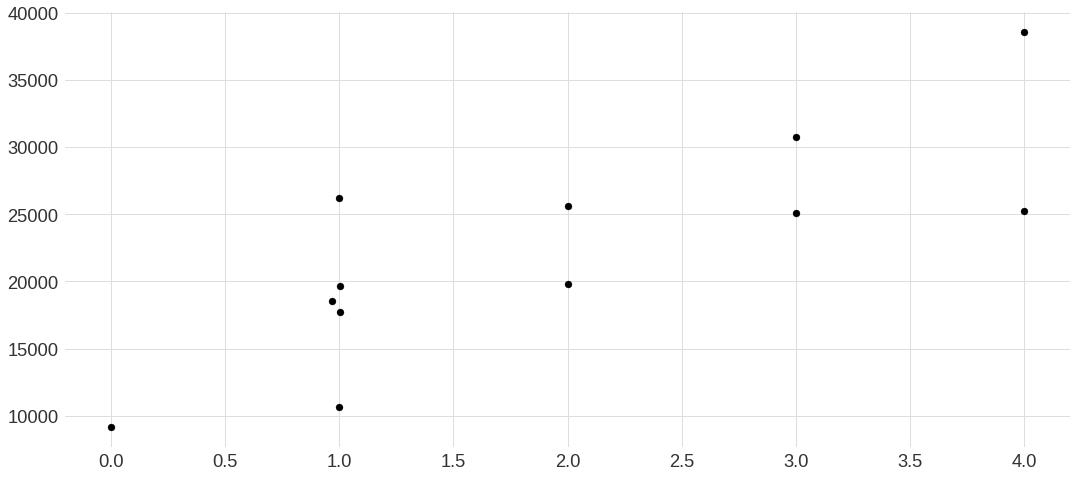

In [57]:
EVALUATE = True
results = odm.evaluate()
#plt.scatter(results[0],results[1])

plt.scatter(results['error_evaluation'],results['cost_evaluation'])

# results = results.append(odm.evaluate_no_control_case(), ignore_index=True)
# results = results.join(runtime_df, how='left', on='model')

results

In [58]:
'''line = pd.DataFrame({
    'Goals Conceded': [0, 2],
    'Goals': [0, 2],
})

line_plot = alt.Chart(line).mark_line(color= 'red').encode(
    x= 'Goals Conceded',
    y= 'Goals'.
)

line_plot'''

"line = pd.DataFrame({\n    'Goals Conceded': [0, 2],\n    'Goals': [0, 2],\n})\n\nline_plot = alt.Chart(line).mark_line(color= 'red').encode(\n    x= 'Goals Conceded',\n    y= 'Goals'.\n)\n\nline_plot"

In [59]:
chart = alt.Chart(results.loc[results.model != 'Fact (no control)']).mark_circle(size=500).encode(
    x='error_evaluation:Q',
    y=alt.Y('cost_evaluation:Q'),
    color=alt.Color('model:N'),
    tooltip = ['model:N','error_evaluation:Q','cost_evaluation:Q']
).properties(width=600, height=600)

chart2 = alt.Chart(results.loc[results.model == 'Fact (no control)']).mark_circle(size=500).encode(
    x='error_evaluation:Q',
    y=alt.Y('cost_evaluation:Q'),
    color=alt.Color('model:N'),
    tooltip = ['model:N','error_evaluation:Q','cost_evaluation:Q']
).properties(width=600, height=600)


chart +chart2+ chart.transform_regression('error_evaluation', 'cost_evaluation', method='poly', order=4).mark_line()

alt.LayerChart(...)

In [ ]:
# results.to_csv('results/VOF_20m_90d_h120.csv')